# **Ocean Mixing Story Group 1**

## Background 
The ocean plays a crucial role in the global carbon cycle by absorbing atmospheric CO₂, having absorbed 38% of all anthropogenic fossil fuel emissions over the industrial era. 

Accurate estimation of air–sea CO₂ flux is critical for understanding the current and future global carbon budget, yet remains challenging due to the sparse and unevenly distributed nature of surface ocean pCO₂ observations. The **Surface Ocean CO₂ Atlas (SOCAT)** database (https://socat.info/) provides the most extensive dataset available, but its coverage is limited to only about 2% of all boxes of 1 degree X 1 degree (= 100km X 100km at the equator) over the last several decades. Data are particularly limited in high-latitude regions and during winter months.

To fill in the gaps in these data, statistical and machine learning (ML) techniques have been widely used to reconstruct global pCO₂ fields by interpolating between observations using environmental predictors such as sea surface temperature (SST), sea surface salinity (SSS), mixed layer depth (MLD), chlorophyll-a (Chl-a), and atmospheric CO₂ (xCO₂).

## How good are these methods? 

This project has two goals:
**Determine the statistical confidance and variability of the pCO₂ reconstructions across the globe** 
**Investigate how adding more observations affects statistical confidence and variability**

Results from this investigation will help answer whether adding data will improve the confidence of the models generally. Going a step deeper, this investigation can give insight into whether it is more important to add more observations in locations historically sampled, or in locations not in the database. Relatedly, this research can inform which areas of the globe are most important to direct funding towards sampling, or to focus other statistical technique to improve model confidence. 

By gaining more confidence in pCO2 reconstructions, scientists can more accurately answer questions related to carbon budgets and other scientific and socio-economic questions related to climate change. 

## Information about the ML model used

## Information about Adding Observations

In section 2, there is an investigation of how adding data to the model affects statistical confidence and variability. In particular, we investigate adding data across 2 dimensions:

1. Adding more observations at locations that have historically been sampled. 
2. Adding new locations, not previously sampled for pCO2 concentrations.

For adding more observations to locations that have historically been sampled, chose to do XXXX(add later depending on what works)

In particular, this research will focus on adding samples to 4 Ocean Basins undersampled in the research: Southern Ocean, Indian Ocean, Arctic Areas, and Pacific Ocean between Australia and South America.  

In [1]:
your_username = 'azamkhan99'  # username of the person running the code. Reviewers should also change this to their own username.

#To allow the reviewer to access the saved files, provide notebook owner's username here:  
owner_username = 'azamkhan99'  # Reviewer should not change this name

# 0. Setup Workspace and Import Packages
We use %%capture to suppress output and keep the notebook clean. However, feel free to remove it if you want to check warnings or logs.


In [2]:
%%capture
!pip install tensorflow
!pip install keras

In [3]:
%%capture
### standard imports ###
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs
### Python file with supporting functions ###
# standard imports
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sys
# Redirect all low-level stderr output
sys.stderr = open(os.devnull, 'w')

import datetime
from collections import defaultdict
import random
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth',100)
import csv
import cmocean as cm

# machine learning libraries
import xgboost as xgb     
from xgboost import XGBRegressor

# Change to the parent directory of the current working directory. (Run only once—otherwise it will keep moving up the directory tree)
os.chdir(os.path.dirname(os.getcwd()))
print("Current working directory:", os.getcwd())

# Python file with supporting functions
import lib.residual_utils as supporting_functions
from lib.visualization import *
from lib.bias_figure2 import concat_datasets, XarrayEvaluator
from lib.corr_figure3 import eval_spatial


In [5]:
### Setting the date range to unify the date type ###

# Define date range
date_range_start = '2004-01-01T00:00:00.000000000'
date_range_end = '2023-12-31T00:00:00.000000000'

# create date vector, adds 14 days to start & end
dates = pd.date_range(start=date_range_start, 
                      end=date_range_end,freq='MS')


init_date = str(dates[0].year) + format(dates[0].month,'02d')
fin_date = str(dates[-1].year) + format(dates[-1].month,'02d')

# 1. Surface ocean pCO2: A sparse data challenge

Here, we visualize all SOCAT data for the period selected for this analysis (default is 2004-2023). 

We plot the total number of months of available data at each 1 degree X 1 degree location (100x100km at the equator). 

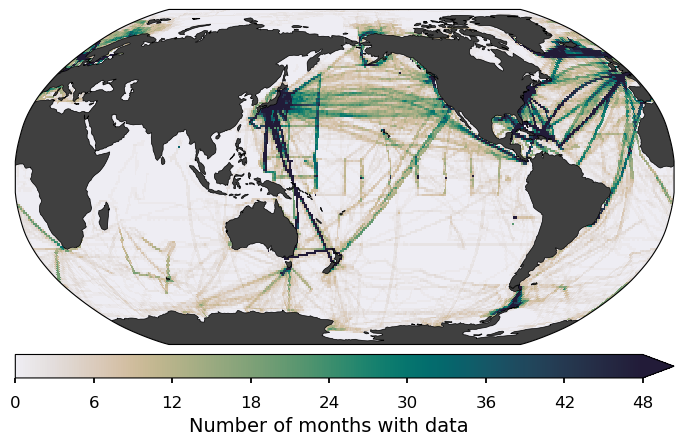

In [6]:
zarr_dir = 'gs://leap-persistent/abbysh/zarr_files_'
socat_path = f"{zarr_dir}/socat_mask_feb1982-dec2023.zarr"
socat_mask_data = xr.open_zarr(socat_path).sel(time=slice(str(dates[0]),str(dates[-1])))

non_zero_counts = (socat_mask_data.socat_mask != 0).sum(dim="time")
plot_style = "seaborn-v0_8-talk"

with plt.style.context(plot_style):
    fig = plt.figure(figsize=(8.5, 11)) # fig = plt.figure(dpi=300)
    worldmap = SpatialMap2(fig=fig, region='world', 
                   cbar_mode='each',
                   colorbar=True,
                   cbar_location='bottom',
                   nrows_ncols=[1,1])
    
    vrange = [0, 48, 6]
    cmap = cm.cm.rain
    data = xr_add_cyclic_point(non_zero_counts, cyclic_coord='xlon')
    data = data.assign_coords(xlon=(((data.xlon + 180) % 360) ))
    sub = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                      vrange=vrange[0:2], cmap=cmap, ax=0, linewidth_coast=0.5)
    
    col = worldmap.add_colorbar(sub, ax=0,extend='max')
    worldmap.set_cbar_xlabel(col, 'Number of months with data', fontsize=14)
    worldmap.set_ticks(col, vrange[0], vrange[1], vrange[2])
    col.ax.tick_params(labelsize=12)
    plt.show()

In [7]:
#socat_mask_data.where(non_zero_counts == 0, socat_mask_data.max(dim='ylat'))
indices = non_zero_counts.where(non_zero_counts == 5).coords
index_list = list(zip(indices['xlon'].values, indices['ylat'].values))
#print(index_list[0])
#-179.5, -89.5
index_list[50][1]
#non_zero_counts.sel(xlon = -179.5, ylat = -89.5).values
test = non_zero_counts.where(non_zero_counts == 5)
test[14][7]

socat_mask_data.sel(xlon = -172.5, ylat = -75.5).values

<bound method Mapping.values of <xarray.Dataset> Size: 4kB
Dimensions:     (time: 240)
Coordinates:
  * time        (time) datetime64[ns] 2kB 2004-01-01 2004-02-01 ... 2023-12-01
    xlon        float64 8B -172.5
    ylat        float64 8B -75.5
Data variables:
    socat_mask  (time) float64 2kB dask.array<chunksize=(52,), meta=np.ndarray>>

In [8]:
socat_mask_data

<xarray.Dataset> Size: 124MB
Dimensions:     (time: 240, ylat: 180, xlon: 360)
Coordinates:
  * time        (time) datetime64[ns] 2kB 2004-01-01 2004-02-01 ... 2023-12-01
  * xlon        (xlon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * ylat        (ylat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Data variables:
    socat_mask  (time, ylat, xlon) float64 124MB dask.array<chunksize=(52, 45, 90), meta=np.ndarray>

In [9]:
#non_zero_counts.sum().item()
#287,121 instances
socat_mask_data.sum()

<xarray.Dataset> Size: 8B
Dimensions:     ()
Data variables:
    socat_mask  float64 8B dask.array<chunksize=(), meta=np.ndarray>

In [ ]:
def plot_mask(mask, title):
    with plt.style.context(plot_style):
        fig = plt.figure(figsize=(8.5, 11)) # fig = plt.figure(dpi=300)
        worldmap = SpatialMap2(fig=fig, region='world', 
                    cbar_mode='each',
                    colorbar=True,
                    cbar_location='bottom',
                    nrows_ncols=[1,1])
        
        vrange = [0, 48, 6]
        cmap = cm.cm.rain
        data = xr_add_cyclic_point(mask, cyclic_coord='xlon')
        data = data.assign_coords(xlon=(((data.xlon + 180) % 360) ))
        sub = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                        vrange=vrange[0:2], cmap=cmap, ax=0, linewidth_coast=0.5)
        
        col = worldmap.add_colorbar(sub, ax=0,extend='max')
        worldmap.set_cbar_xlabel(col, 'Number of months with data', fontsize=14)
        worldmap.set_ticks(col, vrange[0], vrange[1], vrange[2])
        col.ax.tick_params(labelsize=12)
        worldmap.set_title(title, ax=0, fontsize=14)
        plt.show()


In [148]:
#if there's real world data sampled at the location, say it's sampled more
#no change in distribution of sampling
mean_val_glob_loc = non_zero_counts.where((non_zero_counts > non_zero_counts.mean())|(non_zero_counts == 0), 5)
socat_mean_glob = socat_mask_data.where((non_zero_counts > non_zero_counts.mean())|(non_zero_counts == 0), socat_mask_data.sel(xlon = -172.5, ylat = -75.5))

thirtyp_val_glob  = non_zero_counts.where((non_zero_counts > 7)|(non_zero_counts == 0), 7)
socat_30p_glob = socat_mask_data.where((non_zero_counts > 7)|(non_zero_counts == 0), socat_mask_data.where(non_zero_counts == 7))
fiftyp_val_glob = non_zero_counts.where((non_zero_counts > 10)|(non_zero_counts == 0), 10)
socat_50p_glob = socat_mask_data.where((non_zero_counts > 9)|(non_zero_counts == 0), socat_mask_data.where(non_zero_counts == 9))

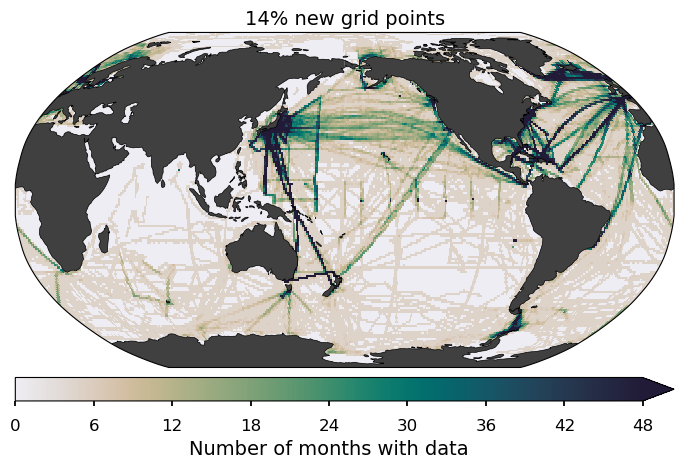

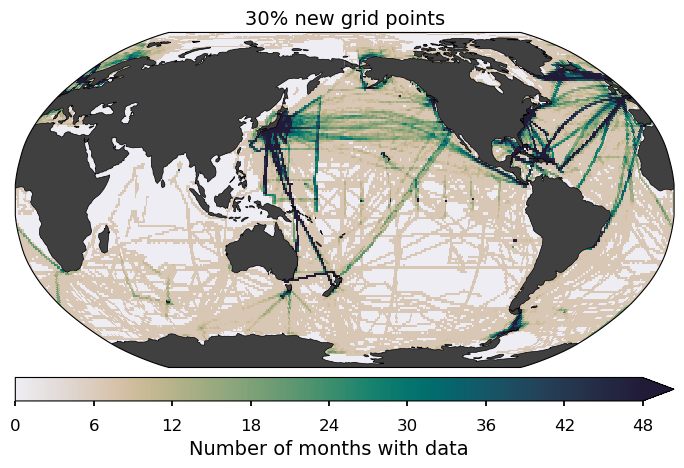

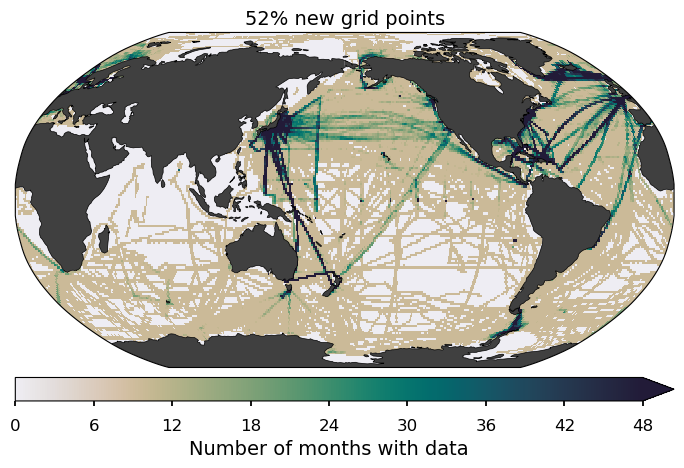

In [155]:
plot_mask(mean_val_glob_loc, "14% new grid points")
plot_mask(thirtyp_val_glob, "30% new grid points")
plot_mask(fiftyp_val_glob, "52% new grid points")


In [10]:
# helper ----------------------------------------------------------
def _stamp_region(ocean_da, socat_ds, lat1, lat2, lon1, lon2, val):
    """
    Fill a rectangular lat/lon window of `ocean_da` with `val`
    and copy the corresponding slice of the original SOCAT mask
    into the same window of `socat_ds['socat_mask']`.

    All inputs are **coordinate labels** (°), not integer indices.
    """
    # always build ascending slices for .loc
    lat_slice = slice(min(lat1, lat2), max(lat1, lat2))
    lon_slice = slice(min(lon1, lon2), max(lon1, lon2))

    ocean_da.loc[dict(ylat=lat_slice, xlon=lon_slice)] = val

    socat_ds["socat_mask"].loc[dict(ylat=lat_slice, xlon=lon_slice)] = (
        socat_mask_data["socat_mask"]  # original mask
        .loc[dict(ylat=lat_slice, xlon=lon_slice)]
        .where(non_zero_counts == val)  # keep dtype / nans consistent
    )


# -----------------------------------------------------------------
# 14 % scenario ----------------------------------------------------
add14p_oceans = non_zero_counts.copy()
add14p_socat = socat_mask_data.copy()

_stamp_region(add14p_oceans, add14p_socat, -46, -36, -97, -87, 34)  # Pacific‑1
_stamp_region(add14p_oceans, add14p_socat, -45, -35, -130, -110, 34)  # Pacific‑2
_stamp_region(add14p_oceans, add14p_socat, -32, -27, -141, -121, 34)  # Pacific‑3
_stamp_region(add14p_oceans, add14p_socat, -90, -70, 90, 110, 34)  # Southern Ocean
_stamp_region(add14p_oceans, add14p_socat, -11, 9, 75, 85, 33)  # Indian‑1
_stamp_region(add14p_oceans, add14p_socat, -30, -25, 70, 90, 33)  # Indian‑2

# 30 % scenario ----------------------------------------------------
add30p_oceans = non_zero_counts.copy()
add30p_socat = socat_mask_data.copy()

_stamp_region(add30p_oceans, add30p_socat, -46, -36, -97, -87, 73)
_stamp_region(add30p_oceans, add30p_socat, -45, -35, -130, -110, 73)
_stamp_region(add30p_oceans, add30p_socat, -32, -27, -141, -121, 73)
_stamp_region(add30p_oceans, add30p_socat, -90, -70, 90, 110, 73)
_stamp_region(add30p_oceans, add30p_socat, -11, 9, 75, 85, 72)
_stamp_region(add30p_oceans, add30p_socat, -30, -25, 70, 90, 72)

# 52 % scenario ----------------------------------------------------
add52p_oceans = non_zero_counts.copy()
add52p_socat = socat_mask_data.copy()

_stamp_region(add52p_oceans, add52p_socat, -46, -36, -97, -87, 125)
_stamp_region(add52p_oceans, add52p_socat, -45, -35, -130, -110, 125)
_stamp_region(add52p_oceans, add52p_socat, -32, -27, -141, -121, 125)
_stamp_region(add52p_oceans, add52p_socat, -90, -70, 90, 110, 125)
_stamp_region(add52p_oceans, add52p_socat, -11, 9, 75, 85, 125)
_stamp_region(add52p_oceans, add52p_socat, -30, -25, 70, 90, 125)


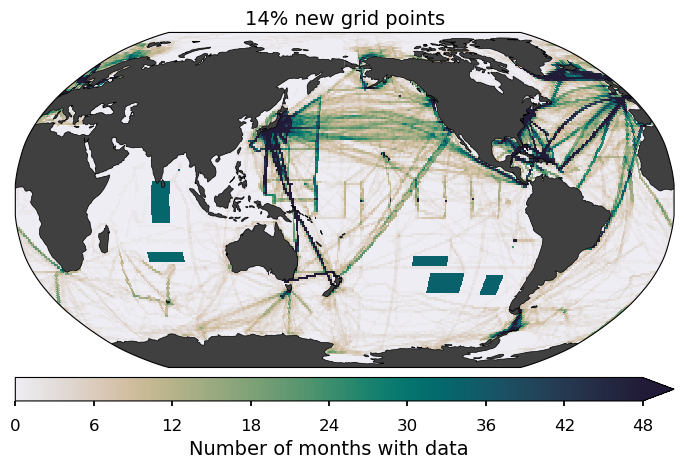

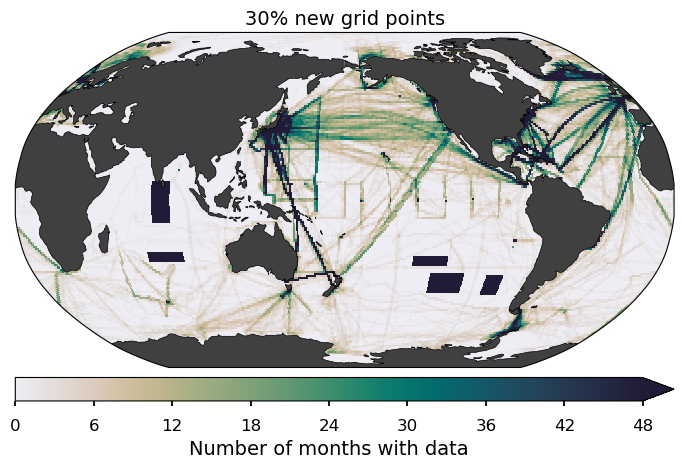

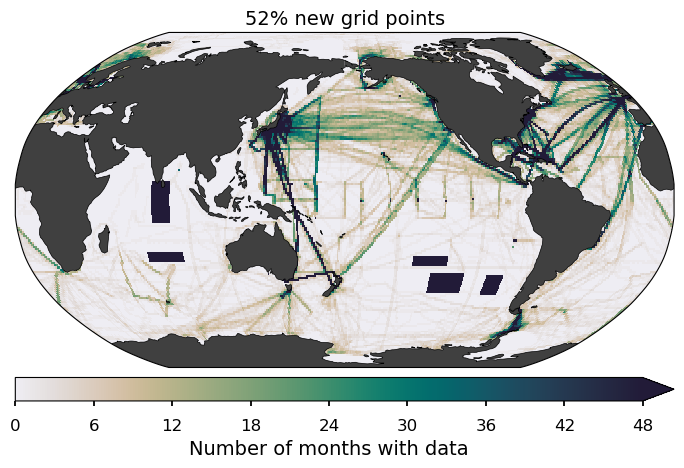

In [150]:

plot_mask(add14p_oceans, "14% new grid points")
plot_mask(add30p_oceans, "30% new grid points")
plot_mask(add52p_oceans, "52% new grid points")

In [12]:
##Will take this out, but checking for 
#Pzeros = pacific.where(pacific ==0)
#pacific25 = non_zero_counts.sel(xlon=slice(-95,-90),ylat=slice(-46,-31))
#pacific50 = non_zero_counts.sel(xlon=slice(-95,-90),ylat=slice(-46,-36))
#pacific100 = non_zero_counts.sel(xlon=slice(-97,-87),ylat=slice(-46,-36))
#southern25 = non_zero_counts.sel(xlon=slice(105,110),ylat=slice(-80,-75))
#southern50 = non_zero_counts.sel(xlon=slice(100,110),ylat=slice(-80,-75))
#southern100 = non_zero_counts.sel(xlon=slice(100,110),ylat=slice(-80,-70))

#indian25 = non_zero_counts.sel(xlon=slice(75,80),ylat=slice(-10,-5))
#indian50 = non_zero_counts.sel(xlon=slice(75,85),ylat=slice(-10,-5))
#indian100 = non_zero_counts.sel(xlon=slice(75,85),ylat=slice(-10,0))

#arctic100 = non_zero_counts.sel(xlon=slice(-75,-65),ylat=slice(50,60))
#arctic50 = non_zero_counts.sel(xlon=slice(-75,-65),ylat=slice(55,60))
#arctic25 = non_zero_counts.sel(xlon=slice(-75,-70),ylat=slice(55,60))

#non_zero_counts.sel(xlon=slice(90,110),ylat=slice(55,75)).values

<table style="border-collapse: collapse; width: 100%;">
  <tr>
    <th style="border: 1px solid black;">Region</th>
    <th style="border: 1px solid black;">Latitude Range</th>
    <th style="border: 1px solid black;">Longitude Range</th>
  </tr>
  <tr>
    <td style="border: 1px solid black;">Pacific 1</td>
    <td style="border: 1px solid black;">-46 to -36</td>
    <td style="border: 1px solid black;">-97 to -87</td>
  </tr>
  <tr>
    <td style="border: 1px solid black;">Pacific 2</td>
    <td style="border: 1px solid black;">-45 to -35</td>
    <td style="border: 1px solid black;">-130 to -110</td>
  </tr>
  <tr>
    <td style="border: 1px solid black;">Pacific 3</td>
    <td style="border: 1px solid black;">-32 to -27</td>
    <td style="border: 1px solid black;">-141 to -121</td>
  </tr>
  <tr>
    <td style="border: 1px solid black;">Southern Ocean</td>
    <td style="border: 1px solid black;">-90 to -70</td>
    <td style="border: 1px solid black;">90 to 110</td>
  </tr>
  <tr>
    <td style="border: 1px solid black;">Indian Ocean 1</td>
    <td style="border: 1px solid black;">-11 to 9</td>
    <td style="border: 1px solid black;">75 to 85</td>
  </tr>
  <tr>
    <td style="border: 1px solid black;">Indian Ocean 2</td>
    <td style="border: 1px solid black;">-30 to -25</td>
    <td style="border: 1px solid black;">70 to 90</td>
  </tr>
</table>



## SOCAT Sampling Mask Variants

This notebook investigates how different sampling strategies affect the statistical confidence of pCO₂ reconstructions. The following variants of the SOCAT mask are used:

---

### 🔹 Original Mask

- **`socat_mask_data`**  
  The baseline SOCAT sampling mask, showing where and when surface ocean pCO₂ has been measured.

---

### 🔸 Augmenting Existing Sampled Locations

These variants **increase the number of samples at already-sampled locations** without changing the spatial coverage.

- **`socat_mean_glob`**  
  Boosts under-sampled locations (below global mean) to the global mean number of sampling months.

- **`socat_30p_glob`**  
  Ensures all existing sampled grid cells have at least 7 months of data (≈30% increase).

- **`socat_50p_glob`**  
  Ensures all existing sampled grid cells have at least 10 months of data (≈50% increase).

---

### 🔸 Adding New Sample Locations

These variants **expand the spatial footprint** by adding sampling at new locations in undersampled ocean regions.

- **`addmeanp_socat`**  
  Adds ~14% new grid points in each of the three undersampled basins, sampled at the global mean frequency.

- **`add30p_socat`**  
  Adds 100 new grid points per basin, each with moderate sampling (~7 months).

- **`add50p_socat`**  
  Adds 200 new grid points per basin, each with higher sampling (~10 months).

---

In [14]:
mask_data_dict = {
    # "baseline": socat_mask_data,
    "densify_mean_pattern": socat_mean_glob,
    "densify_30p": socat_30p_glob,
    "densify_50p": socat_50p_glob,
    "expand_14p": add14p_socat,
    "expand_30p": add30p_socat,
    "expand_52p": add52p_socat,
}


In [15]:
non_zero_dict = {
    # "baseline" : non_zero_counts,
    "densify_mean_pattern": mean_val_glob_loc,
    "densify_30p": thirtyp_val_glob,
    "densify_50p": fiftyp_val_glob,
    "expand_14p": add14p_oceans,
    "expand_30p": add30p_oceans,
    "expand_52p": add52p_oceans
    
}

In [16]:
%%capture
!pip install --upgrade ngboost

In [ ]:
def apply_socat_mask_inplace(df: pd.DataFrame, mask_dataset: xr.Dataset) -> None:
    """
    Fast in-place assignment of 'socat_mask' from an xarray.Dataset to a DataFrame with MultiIndex (time, ylat, xlon).

    Parameters:
        df (pd.DataFrame): DataFrame with MultiIndex (time, ylat, xlon)
        mask_dataset (xr.Dataset): xarray dataset containing 'socat_mask' with dims (time, ylat, xlon)

    Returns:
        None (modifies df in-place)
    """
    time = df.index.get_level_values("time").values
    ylat = df.index.get_level_values("ylat").astype(float).values
    xlon = df.index.get_level_values("xlon").astype(float).values

    mask_da = mask_dataset["socat_mask"]
    mask_vals = mask_da.sel(
        time=xr.DataArray(time, dims="points"),
        ylat=xr.DataArray(ylat, dims="points"),
        xlon=xr.DataArray(xlon, dims="points"),
        method="nearest",
    ).values

    if hasattr(mask_vals, "compute"):
        mask_vals = mask_vals.compute()

    df["socat_mask"] = np.nan_to_num(mask_vals, nan=0).astype(int)


In [18]:
import pickle
from pathlib import Path
import gcsfs

def save_ngb_model_locally(model, dates, mask_name, ens, member, username):
    """
    Saves the trained XGBoost model to a local directory.

    Parameters
    ----------
    model : xgboost.sklearn.XGBRegressor
        Trained XGBoost model.

    dates : pandas.DatetimeIndex
        List of dataset dates.

    mask_name : str
        Name of the socat mask used for training.

    ens : str
        Earth System Model name.

    member : str
        Member index (e.g., 'member_r1i1p1f1').
    username : str
        Username of the person running the code. Reviewer should also change this to their own username.
    """

    print("Starting local model saving process...")

    # Ensure the output directory exists
    Path("output/model_saved").mkdir(parents=True, exist_ok=True)

    # Format time information
    init_date = f"{dates[0].year}{dates[0].month:02d}"
    fin_date = f"{dates[-1].year}{dates[-1].month:02d}"

    # Define the local filename
    model_filename = f"{mask_name}_model_pCO2_2D_{ens}_{member.split('_')[-1]}_mon_1x1_{init_date}_{fin_date}.p"
    local_output_dir = "output/model_saved"
    model_path = Path(local_output_dir) / model_filename

    gcsfs_path = f"gs://leap-persistent/{username}/models/{model_filename}"
    fs = gcsfs.GCSFileSystem()

    # Save the model
    try:
        with model_path.open("wb") as f:
            pickle.dump(model, f)
        print(f"Model successfully saved locally at: {model_path}")

        with fs.open(gcsfs_path, "wb") as gcs_file:
            pickle.dump(model, gcs_file)
        print(f"Model successfully saved to GCS at: {gcsfs_path}")
    except Exception as e:
        print(f"Error saving model: {e}")

    print("Local model saving process complete.")


In [19]:
from collections import defaultdict
import pandas as pd
import numpy as np
import datetime
import csv
from ngboost import NGBRegressor
from ngboost.distns import Normal
from ngboost.scores import LogScore
import gcsfs
import lib.residual_utils as supporting_functions

def run_ngboost_with_masks(
    mask_data_dict,
    selected_mems_dict,
    features_sel,
    target_sel,
    year_mon,
    test_year_mon,
    path_seeds,
    MLinputs_path,
    init_date,
    fin_date,
    metrics_output_dir,
    params,
    runthiscell=-1,
    your_username = your_username,
):
    fs = gcsfs.GCSFileSystem()
    if runthiscell:
        random_seeds = np.load(fs.open(path_seeds))
    seed_loc_dict = defaultdict(dict)
    for ens, mem_list in selected_mems_dict.items():
        sub_dictt = {mem: no for no, mem in enumerate(mem_list)}
        seed_loc_dict[ens] = sub_dictt

    val_prop = 0.2
    test_prop = 0.0

    print(datetime.datetime.now())

    if runthiscell == -1:
        print(
            "Reviewing process: Running ML only for the first member of the first ESM."
        )
        first_ens = list(selected_mems_dict.keys())[0]
        first_mem = selected_mems_dict[first_ens][0]
        run_selected_mems_dict = {first_ens: [first_mem]}
    else:
        run_selected_mems_dict = selected_mems_dict

    for mask_name, mask_data in mask_data_dict.items():
        print(f"\nRunning NGBoost for mask: {mask_name}\n")

        for ens, mem_list in run_selected_mems_dict.items():
            for member in mem_list:
                print(ens, member)
                seed_loc = seed_loc_dict[ens][member]
                data_dir = f"{MLinputs_path}/{ens}/{member}"
                fname = f"MLinput_{ens}_{member.split('_')[-1]}_mon_1x1_{init_date}_{fin_date}.pkl"
                file_path = f"{data_dir}/{fname}"

                with fs.open(file_path, "rb") as filee:
                    df = pd.read_pickle(filee)
                    df["year"] = df.index.get_level_values("time").year
                    df["mon"] = df.index.get_level_values("time").month
                    df["year_month"] = (
                        df["year"].astype(str) + "-" + df["mon"].astype(str)
                    )

                    # Replace socat_mask with the new mask
                    apply_socat_mask_inplace(df, mask_data)
                    print("Applied new SOCAT mask")

                    recon_sel = (
                        ~df[features_sel + target_sel + ["net_mask"]].isna().any(axis=1)
                    ) & (
                        (df[target_sel] < 250) & (df[target_sel] > -250)
                    ).to_numpy().ravel()

                    sel = recon_sel & (df["socat_mask"] == 1)

                    train_sel = (
                        (sel & (pd.Series(df["year_month"]).isin(year_mon)))
                        .to_numpy()
                        .ravel()
                    )
                    test_sel = (
                        (sel & (pd.Series(df["year_month"]).isin(test_year_mon)))
                        .to_numpy()
                        .ravel()
                    )

                    X = df.loc[sel, features_sel].to_numpy()
                    y = df.loc[sel, target_sel].to_numpy().ravel()
                    Xtrain = df.loc[train_sel, features_sel].to_numpy()
                    ytrain = df.loc[train_sel, target_sel].to_numpy().ravel()
                    X_test = df.loc[test_sel, features_sel].to_numpy()
                    y_test = df.loc[test_sel, target_sel].to_numpy().ravel()

                    N = Xtrain.shape[0]
                    train_val_idx, train_idx, val_idx, test_idx = (
                        supporting_functions.train_val_test_split(
                            N, test_prop, val_prop, random_seeds, seed_loc
                        )
                    )

                    (
                        X_train_val,
                        X_train,
                        X_val,
                        X_test_tmp,
                        y_train_val,
                        y_train,
                        y_val,
                        y_test_tmp,
                    ) = supporting_functions.apply_splits(
                        Xtrain, ytrain, train_val_idx, train_idx, val_idx, test_idx
                    )

                model = NGBRegressor(
                    Dist=Normal, random_state=random_seeds[5, seed_loc], **params
                )
                model.fit(X_train_val, y_train_val, X_val=X_val, Y_val=y_val)

                # save ngboost model
                save_ngb_model_locally(
                    model, dates, mask_name, ens, member, your_username
                )
                

                y_pred_test = model.predict(X_test)
                pred_dist = model.pred_dist(X_test)

                pred_dist_dict = {
                    "mean_preds": pred_dist.loc,
                    "std_preds": pred_dist.scale,
                }

                test_performance = supporting_functions.evaluate_test(
                    y_test, y_pred_test
                )

                # Save prediction distribution
                rows = [
                    {
                        "ensemble": ens,
                        "member": member,
                        "index": i,
                        "mean_pred": pred_dist_dict["mean_preds"][i],
                        "std_pred": pred_dist_dict["std_preds"][i],
                        "mask": mask_name,
                    }
                    for i in range(len(pred_dist_dict["mean_preds"]))
                ]

                df_out = pd.DataFrame(rows)
                test_dist_fname = f"{metrics_output_dir}/ngb_test_dists_{mask_name}_{init_date}-{fin_date}.csv"
                print("Saving test distribution to", test_dist_fname)
                df_out.to_csv(test_dist_fname, index=False)

                # Save evaluation metrics
                test_row_dict = {"model": ens, "member": member, "mask": mask_name}
                test_row_dict.update(test_performance)
                
                test_perform_fname = f"{metrics_output_dir}/ngb_test_performance_{mask_name}_{init_date}-{fin_date}.csv"  # path for test performance metrics
                file_exists = fs.exists(test_perform_fname)
                with fs.open(test_perform_fname, "a") as f_object:
                    writer = csv.DictWriter(f_object, fieldnames=test_row_dict.keys())
                    if not file_exists:
                        writer.writeheader()
                    writer.writerow(test_row_dict)

                print(f"Test metrics for {mask_name}:", test_performance)

        print(f"Done with mask: {mask_name} at", datetime.datetime.now())


In [20]:
# features for ML:
features_sel = [
    "sst",
    "sst_anom",
    "sss",
    "sss_anom",
    "mld_clim_log",
    "chl_log",
    "chl_log_anom",
    "xco2",
    "A",
    "B",
    "C",
    "T0",
    "T1",
]

# the target variable we reconstruct:
target_sel = [
    "pco2_residual"
]  # this represents pCO2 - pCO2-T (calculated in notebook 00)


In [21]:
### train-validate-test split proportions ###

select_dates = []
test_dates = []

for i in range(0, len(dates)):
    if i % 5 != 0:
        select_dates.append(dates[i])  ### 80% train days set ###
    if i % 5 == 0:
        test_dates.append(dates[i])  ### 20% test days set ###

### Then, the month numbers above are converted back to their respective datetime objects.

year_mon = []

for i in range(0, len(select_dates)):
    tmp = select_dates[i]
    year_mon.append(f"{tmp.year}-{tmp.month}")

test_year_mon = []

for i in range(0, len(test_dates)):
    tmp = test_dates[i]
    test_year_mon.append(f"{tmp.year}-{tmp.month}")


In [33]:
path_seeds = (
    "gs://leap-persistent/abbysh/pickles/random_seeds.npy"  # random seeds for ML
)
grid_search_approach = "nmse"
MLinputs_path = "gs://leap-persistent/Mukkke/pco2_residual/post01_xgb_inputs"
output_dir = f"gs://leap-persistent/{your_username}/{owner_username}/pco2_residual/{grid_search_approach}/post02_xgb"  # where to save machine learning results
metrics_output_dir = f"{output_dir}/metrics"  # where to save performance metrics
test_perform_fname = f"{metrics_output_dir}/ngb_test_performance_{init_date}-{fin_date}.csv"  # path for test performance metrics

In [23]:
ngb_params = {
    "n_estimators": 500,  # Number of boosting rounds
    "learning_rate": 0.05,  # Learning rate
    "natural_gradient": True,  # Use natural gradient
    "minibatch_frac": 0.8,  # Proportion of data used per iteration
    "col_sample": 0.8,  # Feature proportion per tree
    "verbose": True,  # Disable training output
    "Score": LogScore,  # Loss function
    "early_stopping_rounds": 25,  # Early stopping rounds
}


In [24]:
selected_mems_dict_no_mpi = {
    "ACCESS-ESM1-5": ["member_r10i1p1f1", "member_r5i1p1f1", "member_r2i1p1f1"],
    # "CanESM5": ["member_r2i1p1f1", "member_r1i1p2f1", "member_r1i1p1f1"],
}


In [25]:
# Call the function
run_ngboost_with_masks(
    mask_data_dict=mask_data_dict,
    selected_mems_dict=selected_mems_dict_two_mems,
    features_sel=features_sel,
    target_sel=target_sel,
    year_mon=year_mon,
    test_year_mon=test_year_mon,
    path_seeds=path_seeds,
    MLinputs_path=MLinputs_path,
    init_date=init_date,
    fin_date=fin_date,
    metrics_output_dir=metrics_output_dir,
    params=ngb_params,  # NGBoost parameters
    runthiscell=-1,  # -1 = first member of first ensemble only (use 1 to run all)
    your_username=your_username,  # username of the person running the code. Reviewer should also change this to their own username.
)


2025-04-23 14:50:51.965048
Reviewing process: Running ML only for the first member of the first ESM.

Running NGBoost for mask: densify_mean_pattern

ACCESS-ESM1-5 member_r2i1p1f1
Applied new SOCAT mask
Using passed validation data to check for early stopping.
[iter 0] loss=4.7779 val_loss=4.7421 scale=1.0000 norm=21.3006
[iter 100] loss=3.9654 val_loss=3.9621 scale=1.0000 norm=11.6861
[iter 200] loss=3.8073 val_loss=3.8052 scale=1.0000 norm=9.9974
[iter 300] loss=3.7281 val_loss=3.7236 scale=1.0000 norm=9.2032
[iter 400] loss=3.6729 val_loss=3.6689 scale=1.0000 norm=8.6820
Starting local model saving process...
Model successfully saved locally at: output/model_saved/densify_mean_pattern_model_pCO2_2D_ACCESS-ESM1-5_r2i1p1f1_mon_1x1_200401_202312.p
Model successfully saved to GCS at: gs://leap-persistent/azamkhan99/models/densify_mean_pattern_model_pCO2_2D_ACCESS-ESM1-5_r2i1p1f1_mon_1x1_200401_202312.p
Local model saving process complete.
Saving test distribution to gs://leap-persistent

In [ ]:
stop here

In [25]:
seed_loc_dict = defaultdict(dict)
for ens, mem_list in selected_mems_dict_no_mpi.items():
    sub_dictt = {mem: no for no, mem in enumerate(mem_list)}
    seed_loc_dict[ens] = sub_dictt

In [ ]:
fs = gcsfs.GCSFileSystem()
def run_reconstruction_with_masks(
    mask_data_dict,
    selected_mems_dict,
    features_sel,
    target_sel,
    year_mon,
    test_year_mon,
    seed_loc_dict,
    MLinputs_path,
    init_date,
    fin_date,
    dates,
    runthiscell=1,
    username=None,
):
    if runthiscell == -1:
        print(
            "Reviewing process: Running reconstruction only for the first member of the first ESM."
        )
        first_ens = list(selected_mems_dict.keys())[0]
        first_mem = selected_mems_dict[first_ens][0]
        run_selected_mems_dict = {first_ens: [first_mem]}
    else:
        run_selected_mems_dict = selected_mems_dict
        
    # Save summary of mask coverage
    summary_rows = []
    for mask_name, mask_data in mask_data_dict.items():
        print(f"\nRunning reconstruction for mask: {mask_name}\n")

        for ens, mem_list in run_selected_mems_dict.items():
            for member in mem_list:
                print(ens, member)
                seed_loc = seed_loc_dict[ens][member]
                data_dir = f"{MLinputs_path}/{ens}/{member}"
                fname = f"MLinput_{ens}_{member.split('_')[-1]}_mon_1x1_{init_date}_{fin_date}.pkl"
                file_path = f"{data_dir}/{fname}"

                # Load the model
                model_filename = f"{mask_name}_model_pCO2_2D_{ens}_{member.split('_')[-1]}_mon_1x1_{init_date}_{fin_date}.p"
                if username:
                    model_path = f"gs://leap-persistent/{username}/models/{model_filename}"
                    with fs.open(model_path, "rb") as f:
                        model = pickle.load(f)
                    print(f"Model loaded from GCS at: {model_path}")

                else:
                    local_output_dir = "output/model_saved"
                    model_path = Path(local_output_dir) / model_filename

                    with open(model_path, "rb") as f:
                        model = pickle.load(f)
                    print(f"Model loaded from local path: {model_path}")

                

                with fs.open(file_path, "rb") as filee:
                    df = pd.read_pickle(filee)
                    df["year"] = df.index.get_level_values("time").year
                    df["mon"] = df.index.get_level_values("time").month
                    df["year_month"] = (
                        df["year"].astype(str) + "-" + df["mon"].astype(str)
                    )

                    # Replace socat_mask with the new mask
                    apply_socat_mask_inplace(df, mask_data)
                    print("Applied new SOCAT mask")

                    recon_sel = (
                        ~df[features_sel + target_sel + ["net_mask"]].isna().any(axis=1)
                    ) & (
                        (df[target_sel] < 250) & (df[target_sel] > -250)
                    ).to_numpy().ravel()

                    sel = recon_sel & (df["socat_mask"] == 1)
                    train_sel = (
                        (sel & (pd.Series(df["year_month"]).isin(year_mon)))
                        .to_numpy()
                        .ravel()
                    )
                    test_sel = (
                        (sel & (pd.Series(df["year_month"]).isin(test_year_mon)))
                        .to_numpy()
                        .ravel()
                    )
                    unseen_sel = recon_sel & (df["socat_mask"] == 0)

                    print(f"Total selected locations for training ({mask_name}):", sel.sum())
                    print(f"Total unseen locations ({mask_name}):", unseen_sel.sum())


                    X = df.loc[sel, features_sel].to_numpy()
                    y = df.loc[sel, target_sel].to_numpy().ravel()

                y_pred_unseen = model.predict(
                    df.loc[unseen_sel, features_sel].to_numpy()
                )
                y_dists_unseen = model.pred_dist(
                    df.loc[unseen_sel, features_sel].to_numpy()
                )
                y_unseen = df.loc[unseen_sel, target_sel].to_numpy().ravel()

                unseen_performance = defaultdict(dict)
                unseen_performance[ens][member] = supporting_functions.evaluate_test(
                    y_unseen, y_pred_unseen
                )

                fields = unseen_performance[ens][member].keys()
                unseen_row_dict = {"model": ens, "member": member, "mask": mask_name}
                for field in fields:
                    unseen_row_dict[field] = unseen_performance[ens][member][field]

                unseen_perform_fname = f"{metrics_output_dir}/ngb_unseen_performance_{mask_name}_{init_date}-{fin_date}.csv"  # path for unseen performance metrics

                file_exists = fs.exists(unseen_perform_fname)
                with fs.open(unseen_perform_fname, "a") as f_object:
                    writer = csv.DictWriter(f_object, fieldnames=unseen_row_dict.keys())
                    if not file_exists:
                        writer.writeheader()
                    writer.writerow(unseen_row_dict)

                print(f"unseen performance metrics for {mask_name}:", unseen_performance[ens][member])

                y_pred_seen = model.predict(X)
                y_dists_seen = model.pred_dist(X)

                df["pCO2_recon_full"] = np.nan
                df.loc[unseen_sel, "pCO2_recon_full"] = y_pred_unseen
                df.loc[unseen_sel, "pCO2_recon_full_mean"] = y_dists_unseen.loc
                df.loc[unseen_sel, "pCO2_recon_full_std"] = y_dists_unseen.scale
                df.loc[sel, "pCO2_recon_full"] = y_pred_seen
                df.loc[sel, "pCO2_recon_full_mean"] = y_dists_seen.loc
                df.loc[sel, "pCO2_recon_full_std"] = y_dists_seen.scale

                df["pCO2_recon_unseen"] = np.nan
                df.loc[unseen_sel, "pCO2_recon_unseen"] = y_pred_unseen
                df.loc[unseen_sel, "pCO2_recon_unseen_mean"] = y_dists_unseen.loc
                df.loc[unseen_sel, "pCO2_recon_unseen_std"] = y_dists_unseen.scale
                df.loc[sel, "pCO2_recon_unseen"] = np.nan

                df["pCO2_truth"] = df.loc[:, target_sel]

                DS_recon = df[
                    [
                        "net_mask",
                        "socat_mask",
                        "pCO2_recon_full",
                        "pCO2_recon_unseen",
                        "pCO2_truth",
                        "pCO2_recon_full_mean",
                        "pCO2_recon_full_std",
                        "pCO2_recon_unseen_mean",
                        "pCO2_recon_unseen_std",
                    ]
                ].to_xarray()
                recon_output_dir = f"{output_dir}/reconstructions/{mask_name}"
                supporting_functions.save_recon(
                    DS_recon, dates, recon_output_dir, ens, member
                )

                

                summary_rows.append(
                    {
                        "mask": mask_name,
                        "member": member,
                        "seen_count": int(sel.sum()),
                        "unseen_count": int(unseen_sel.sum()),
                    }
                )
    pd.DataFrame(summary_rows).to_csv(
        f"{metrics_output_dir}/mask_coverage_summary.csv", index=False
    )

    print("end of all members", datetime.datetime.now())


In [59]:
run_reconstruction_with_masks(
    mask_data_dict=mask_data_dict,
    selected_mems_dict=selected_mems_dict_no_mpi,
    features_sel=features_sel,
    target_sel=target_sel,
    year_mon=year_mon,
    test_year_mon=test_year_mon,
    seed_loc_dict=seed_loc_dict,
    MLinputs_path=MLinputs_path,
    init_date=init_date,
    fin_date=fin_date,
    dates=dates,
    runthiscell=1,  # -1 = first member of first ensemble only (use 1 to run all)
    username=your_username,  # username of the person running the code. Reviewer should also change this to their own username.
)


Running reconstruction for mask: densify_mean_pattern

ACCESS-ESM1-5 member_r10i1p1f1
Model loaded from GCS at: gs://leap-persistent/azamkhan99/models/densify_mean_pattern_model_pCO2_2D_ACCESS-ESM1-5_r10i1p1f1_mon_1x1_200401_202312.p
Applied new SOCAT mask
unseen performance metrics for densify_mean_pattern: {'mse': 214.26396644942957, 'mae': 9.701473412291781, 'medae': np.float64(6.860104976704477), 'max_error': np.float64(262.4659318371382), 'bias': np.float64(-0.516734135285466), 'r2': 0.6937840698255299, 'corr': np.float64(0.8340626823404753), 'cent_rmse': np.float64(14.628634669129593), 'stdev': np.float64(21.03999795376493), 'amp_ratio': np.float64(0.9508219709097566), 'stdev_ref': np.float64(26.452131930719922), 'range_ref': np.float64(499.3369458048631), 'iqr_ref': np.float64(28.784064916586104)}
Starting reconstruction saving process
gs://leap-persistent/azamkhan99/azamkhan99/pco2_residual/nmse/post02_xgb/reconstructions/densify_mean_pattern/ACCESS-ESM1-5/member_r10i1p1f1/rec

In [60]:
def calc_recon_pco2(
    regridded_members_dir,
    pco2_recon_dir,
    selected_mems_dict,
    mask_name,
    init_date,
    fin_date,
    owner_name=None,
):
    """
    Calculates reconstructed pco2 per member.

    Parameters
    ----------
    regridded_members_dir : str
        Path to regridded data from notebook 00, which contains pco2T.

    pco2_recon_dir : str
        Path to directory where ML reconstructions from notebook 02 are saved.
    """
    init_date_sel = pd.to_datetime(init_date, format="%Y%m")
    fin_date_sel = pd.to_datetime(fin_date, format="%Y%m")

    if owner_name:
        print(
            "Reviewing process: Running ML only for the first member of the first ESM, loading remaining reconstructed data from the notebook owner."
        )
        first_ens = list(selected_mems_dict.keys())[0]  # Get the first ensemble key
        first_mem = selected_mems_dict[first_ens][
            0
        ]  # Get the first member in that ensemble
        run_selected_mems_dict = {
            first_ens: [first_mem]
        }  # Create a dictionary with only the first ensemble and member
        grid_search_approach = "nmse"
        owener_output_dir = f"gs://leap-persistent/{owner_name}/{owner_name}/pco2_residual/{grid_search_approach}/post02_xgb"  # where to save machine learning results
        owener_recon_output_dir = f"{owener_output_dir}/reconstructions/{mask_name}"  # where owner save ML reconstructions

    else:
        run_selected_mems_dict = selected_mems_dict

    for ens, mem_list in run_selected_mems_dict.items():
        print(f"Current ESM: {ens}")

        for member in mem_list:
            print(f"On member {member}")

            ### File paths ###

            ### Path to regridded data from notebook 00, so we can get the pCO2-T we calculated in 00
            ### pCO2-T calculated from model pCO2 and SST
            pco2T_path = f"{regridded_members_dir}/{ens}/{member}/{ens}.{member.split('_')[-1]}.Omon.zarr"
            print("pco2T path:", pco2T_path)

            
            
            ### Path to reconstruction (ML output from notebook 02), where pCO2-residual was reconstructed
            pCO2R_path = f"{pco2_recon_dir}/{ens}/{member}/recon_pCO2residual_{ens}_{member}_mon_1x1_{init_date}_{fin_date}.zarr"
            print("pCO2R path:", pCO2R_path)

            ### Path to save calculated pCO2 (reconstructed pCO2-residual PLUS pCO2-T: Total pCO2 =  pCO2-residual + pCO2-T)
            file_out = f"{pco2_recon_dir}/{ens}/{member}/recon_pCO2_{ens}_{member}_mon_1x1_{init_date}_{fin_date}.zarr"  # change this to just pco2
            print("save path:", file_out)

            ### Loading pCO2-T and reconstructed pCO2-residual:
            pco2T_series = (
                xr.open_zarr(pco2T_path)
                .pco2_T.transpose("time", "ylat", "xlon")
                .sel(time=slice(init_date_sel, fin_date_sel))
            )
            pco2_ml_output = xr.open_zarr(
                pCO2R_path
            )  # , consolidated=False, storage_options={"token": "cloud"}, group=None)

            ### unseen reconstructed pCO2-Residual from XGB
            pCO2R_unseen_series = pco2_ml_output.pCO2_recon_unseen.transpose(
                "time", "ylat", "xlon"
            )

            pCO2R_unseen_means_series = pco2_ml_output.pCO2_recon_unseen_mean.transpose(
                "time", "ylat", "xlon"
            )
            pCO2R_unseen_stds_series = pco2_ml_output.pCO2_recon_unseen_std.transpose(
                "time", "ylat", "xlon"
            )

            ### Full (seen and unseen) reconstructed pCO2-Residual from XGB
            pCO2R_full_series = pco2_ml_output.pCO2_recon_full.transpose(
                "time", "ylat", "xlon"
            )

            pCO2_full_means_series = pco2_ml_output.pCO2_recon_full_mean.transpose(
                "time", "ylat", "xlon"
            )

            pCO2_full_stds_series = pco2_ml_output.pCO2_recon_full_std.transpose(
                "time", "ylat", "xlon"
            )

            # ### training set for pco2 residual
            # pCO2R_train_series = pco2_ml_output.pCO2_recon_train.transpose("time","ylat","xlon")

            # ### testing set for pco2 residual
            # pCO2R_test_series = pco2_ml_output.pCO2_recon_test.transpose("time","ylat","xlon")

            pCO2R_truth = pco2_ml_output.pCO2_truth.transpose("time", "ylat", "xlon")

            ### Get time coordinate correct
            pco2T_series = pco2T_series.assign_coords(
                {"time": ("time", pCO2R_unseen_series.time.data)}
            )

            ### Total pCO2 =  pCO2-residual + pCO2-T
            pco2_unseen = pco2T_series + pCO2R_unseen_series
            pco2_unseen_means = pco2T_series + pCO2R_unseen_means_series
            pco2_unseen_stds = pco2T_series + pCO2R_unseen_stds_series
            pco2_full = pco2T_series + pCO2R_full_series
            pco2_full_means = pco2T_series + pCO2_full_means_series
            pco2_full_stds = pco2T_series + pCO2_full_stds_series
            # pco2_train =  pco2T_series + pCO2R_train_series
            # pco2_test =  pco2T_series + pCO2R_test_series
            pco2_truth = pco2T_series + pCO2R_truth

            ### Creating xarray of pco2 ML output, but with temperature added back
            comp = xr.Dataset(
                {
                    "pCO2_recon_unseen": (["time", "ylat", "xlon"], pco2_unseen.data),
                    "pCO2_recon_full": (["time", "ylat", "xlon"], pco2_full.data),
                    "pCO2_recon_unseen_mean": (
                        ["time", "ylat", "xlon"],
                        pco2_unseen_means.data,
                    ),
                    "pCO2_recon_unseen_std": (
                        ["time", "ylat", "xlon"],
                        pco2_unseen_stds.data,
                    ),
                    "pCO2_recon_full_mean": (
                        ["time", "ylat", "xlon"],
                        pco2_full_means.data,
                    ),
                    "pCO2_recon_full_std": (
                        ["time", "ylat", "xlon"],
                        pco2_full_stds.data,
                    ),
                    # 'pCO2_recon_train': (["time","ylat","xlon"], pco2_train.data),
                    # 'pCO2_recon_train':(["time","ylat","xlon"],pco2_train.data),
                    # 'pCO2_recon_test':(["time","ylat","xlon"],pco2_test.data),
                    "pCO2_truth": (["time", "ylat", "xlon"], pco2_truth.data),
                },
                coords={
                    "time": (["time"], pco2T_series.time.values),
                    "xlon": (["xlon"], pco2T_series.xlon.values),
                    "ylat": (["ylat"], pco2T_series.ylat.values),
                },
            )

            ### to overwrite file if it exists already
            if fs.exists(file_out):
                fs.rm(file_out, recursive=True)

            ### for saving:
            comp = comp.chunk({"time": 100, "ylat": 45, "xlon": 90})
            comp.to_zarr(file_out, mode="w", zarr_format=2)

            print(f"finished with {member}")

    if owner_name:
        print("Copying remaining members from owner’s directory...")
        for ens, mem_list in selected_mems_dict.items():
            print(f"On member {member}")
            if ens in run_selected_mems_dict:
                remaining_members = [
                    m for m in mem_list if m not in run_selected_mems_dict[ens]
                ]
            else:
                remaining_members = mem_list

            for member in remaining_members:
                owner_file_out = f"{owener_recon_output_dir}/{ens}/{member}/recon_pCO2_{ens}_{member}_mon_1x1_{init_date}_{fin_date}.zarr"
                target_file_out = f"{pco2_recon_dir}/{ens}/{member}/recon_pCO2_{ens}_{member}_mon_1x1_{init_date}_{fin_date}.zarr"

                if fs.exists(owner_file_out):
                    print(f"Copying {owner_file_out} → {target_file_out}")
                    fs.copy(owner_file_out, target_file_out)
                else:
                    print(f"Warning: {owner_file_out} not found. Skipping.")
                print(f"finished with {member}")


In [26]:
ensemble_dir = "gs://leap-persistent/abbysh/pco2_all_members_1982-2023/00_regridded_members"  # path to regridded data
# recon_output_dir = f"{output_dir}/reconstructions/{mask_name}"  # where to save reconstructions

In [27]:
output_dir


'gs://leap-persistent/azamkhan99/azamkhan99/pco2_residual/nmse/post02_xgb'

In [63]:
runthiscell = 1  # 0 will turn off, 1 will turn on, -1 will only run first member

if runthiscell:
    # Use a subset of masks if only testing with the first ensemble member
    if runthiscell == -1:
        mask_data_dict_one = {
            "expand_30p": add30p_socat,
        }
        masks_to_run = mask_data_dict_one.items()
    else:
        masks_to_run = mask_data_dict.items()

    for mask_name, mask_data in masks_to_run:
        print(f"Processing mask: {mask_name}")

        calc_recon_pco2(
            regridded_members_dir=ensemble_dir,
            pco2_recon_dir=f"{output_dir}/reconstructions/{mask_name}",
            selected_mems_dict=selected_mems_dict_no_mpi,
            mask_name=mask_name,
            init_date=init_date,
            fin_date=fin_date,
            owner_name=your_username if runthiscell == -1 else None,
        )

        print(f"Finished processing mask: {mask_name}")


Processing mask: densify_mean_pattern
Current ESM: ACCESS-ESM1-5
On member member_r10i1p1f1
pco2T path: gs://leap-persistent/abbysh/pco2_all_members_1982-2023/00_regridded_members/ACCESS-ESM1-5/member_r10i1p1f1/ACCESS-ESM1-5.r10i1p1f1.Omon.zarr
pCO2R path: gs://leap-persistent/azamkhan99/azamkhan99/pco2_residual/nmse/post02_xgb/reconstructions/densify_mean_pattern/ACCESS-ESM1-5/member_r10i1p1f1/recon_pCO2residual_ACCESS-ESM1-5_member_r10i1p1f1_mon_1x1_200401_202312.zarr
save path: gs://leap-persistent/azamkhan99/azamkhan99/pco2_residual/nmse/post02_xgb/reconstructions/densify_mean_pattern/ACCESS-ESM1-5/member_r10i1p1f1/recon_pCO2_ACCESS-ESM1-5_member_r10i1p1f1_mon_1x1_200401_202312.zarr
finished with member_r10i1p1f1
On member member_r5i1p1f1
pco2T path: gs://leap-persistent/abbysh/pco2_all_members_1982-2023/00_regridded_members/ACCESS-ESM1-5/member_r5i1p1f1/ACCESS-ESM1-5.r5i1p1f1.Omon.zarr
pCO2R path: gs://leap-persistent/azamkhan99/azamkhan99/pco2_residual/nmse/post02_xgb/reconstruct

In [ ]:
from google.cloud import storage

if runthiscell != -1:
    client = storage.Client()
    bucket = client.bucket("leap-persistent")

    for mask_name, mask_data in mask_data_dict.items():
        print(f"Processing mask: {mask_name}")

        # Define the prefix for the blobs you want to make public
        prefix = f"{your_username}/{your_username}/pco2_residual/nmse/post02_xgb/reconstructions/{mask_name}/"
        blobs = bucket.list_blobs(prefix=prefix)

        seen_dirs = (
            set()
        )
        # Track top-level directories (immediate subdirectories of `reconstructions`)
        for blob in blobs:
            # Extract the relative path after `reconstructions/`
            relative_path = blob.name[len(prefix) :]
            top_level_dir = relative_path.split("/")[0]
            # print(relative_path)


            # Get first component
            try:
                # Make the file public
                blob.make_public()

                # Only print if it's a new top-level directory
                if top_level_dir not in seen_dirs:
                    seen_dirs.add(top_level_dir)
                    print(f"Made public: {top_level_dir}")
                    # print(seen_dirs)
            except Exception as e:
                print(f"Failed to make public: {blob.name}")
                print(e)


In [160]:
def plot_reconstruction_vs_truth(
    mask_name,
    mask_data_dict,
    selected_mems_dict_no_mpi,
    ensemble_dir,
    output_dir,
    dates,
    init_date,
    fin_date,
    plot_style="seaborn-v0_8-talk",
    cmap=None,
    vrange=[280, 440],
    chosen_time="2021-01",
):
    import matplotlib.pyplot as plt
    import cmocean.cm as cm
    import numpy as np
    import xarray as xr

    if cmap is None:
        cmap = cm.thermal

    # Select the first ensemble and member
    first_ens = list(selected_mems_dict_no_mpi.keys())[0]
    first_mem = selected_mems_dict_no_mpi[first_ens][0]

    # Load original member data from ESM output
    member_dir = f"{ensemble_dir}/{first_ens}/{first_mem}"
    member_path = fs.glob(f"{member_dir}/*.zarr")[0]
    member_data = xr.open_zarr("gs://" + member_path).sel(
        time=slice(str(dates[0]), str(dates[-1]))
    )
    print("Member path:", member_path)

    # Load reconstructed pCO₂ data
    recon_output_dir = f"{output_dir}/reconstructions/{mask_name}"
    recon_dir = f"{recon_output_dir}/{first_ens}/{first_mem}"
    recon_path = f"{recon_dir}/recon_pCO2_{first_ens}_{first_mem}_mon_1x1_{init_date}_{fin_date}.zarr"
    print("Recon path:", recon_path)
    full = xr.open_zarr(recon_path, consolidated=True)["pCO2_recon_full"]

    # Extract specific month
    raw_data = member_data["spco2"].sel(time=chosen_time).squeeze()
    recon_data = full.sel(time=chosen_time)[0, ...]

    # Shift longitudes for global plotting
    raw_data = raw_data.roll(xlon=len(raw_data.xlon) // 2, roll_coords=True)
    recon_data = recon_data.roll(xlon=len(recon_data.xlon) // 2, roll_coords=True)

    # Load SOCAT mask and align
    mask_data = mask_data_dict[mask_name]
    mask = mask_data.sel(time=chosen_time)["socat_mask"].squeeze()
    mask = mask.roll(xlon=len(mask.xlon) // 2, roll_coords=True)

    # Mask the raw data
    masked_raw = np.ma.masked_array(raw_data, mask=(mask == 0))
    # masked_raw = raw_data

    # Start plotting
    with plt.style.context(plot_style):
        fig = plt.figure(figsize=(8, 3), dpi=200)
        worldmap = SpatialMap2(
            fig=fig,
            region="world",
            cbar_mode="single",
            colorbar=True,
            cbar_location="bottom",
            nrows_ncols=[1, 2],
        )

        sub0 = worldmap.add_plot(
            lon=raw_data["xlon"],
            lat=raw_data["ylat"],
            data=masked_raw,
            vrange=vrange,
            cmap=cmap,
            ax=0,
        )

        sub1 = worldmap.add_plot(
            lon=recon_data["xlon"],
            lat=recon_data["ylat"],
            data=recon_data,
            vrange=vrange,
            cmap=cmap,
            ax=1,
        )

        worldmap.set_title(f"{mask_name} pCO₂ (2021-01)", ax=0, fontsize=13)
        worldmap.set_title("pCO₂ Reconstruction  (2021-01)", ax=1, fontsize=13)

        colorbar = worldmap.add_colorbar(sub0, ax=0)
        worldmap.set_cbar_xlabel(colorbar, "pCO₂ (µatm)", fontsize=12)

        plt.show()


In [161]:
mask_data_dict.keys()

dict_keys(['densify_mean_pattern', 'densify_30p', 'densify_50p', 'expand_14p', 'expand_30p', 'expand_52p'])

### Sampling strategy: adding more locations in under-sampled regions

Member path: leap-persistent/abbysh/pco2_all_members_1982-2023/00_regridded_members/ACCESS-ESM1-5/member_r10i1p1f1/ACCESS-ESM1-5.r10i1p1f1.Omon.zarr
Recon path: gs://leap-persistent/azamkhan99/azamkhan99/pco2_residual/nmse/post02_xgb/reconstructions/expand_14p/ACCESS-ESM1-5/member_r10i1p1f1/recon_pCO2_ACCESS-ESM1-5_member_r10i1p1f1_mon_1x1_200401_202312.zarr


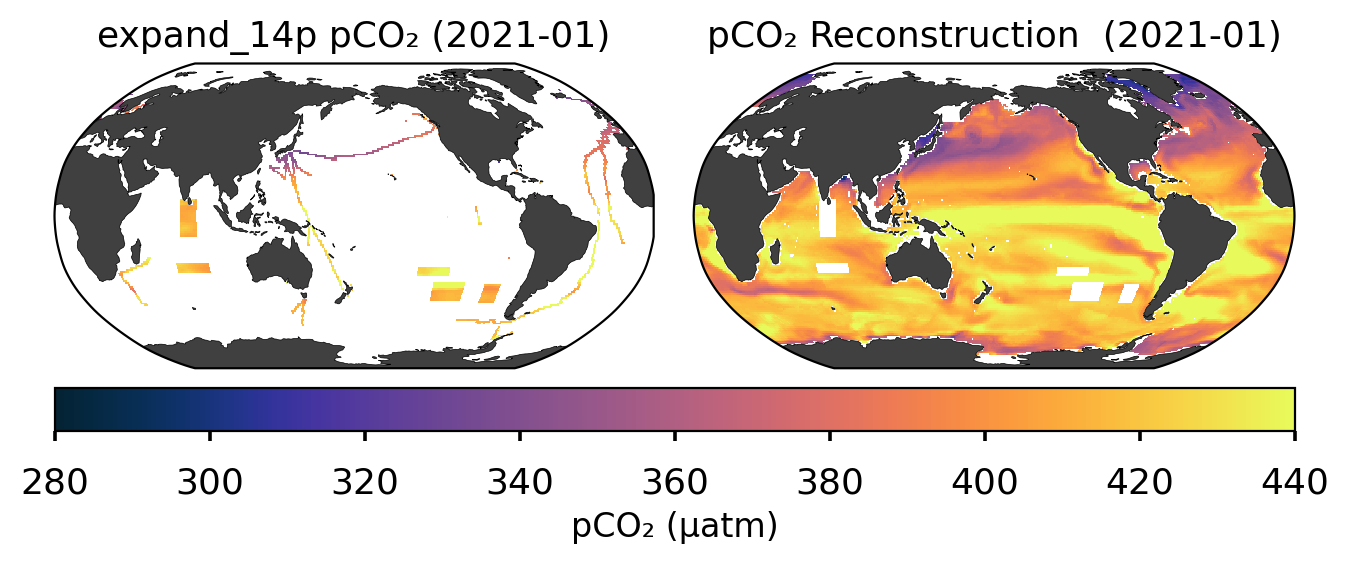

Member path: leap-persistent/abbysh/pco2_all_members_1982-2023/00_regridded_members/ACCESS-ESM1-5/member_r10i1p1f1/ACCESS-ESM1-5.r10i1p1f1.Omon.zarr
Recon path: gs://leap-persistent/azamkhan99/azamkhan99/pco2_residual/nmse/post02_xgb/reconstructions/expand_30p/ACCESS-ESM1-5/member_r10i1p1f1/recon_pCO2_ACCESS-ESM1-5_member_r10i1p1f1_mon_1x1_200401_202312.zarr


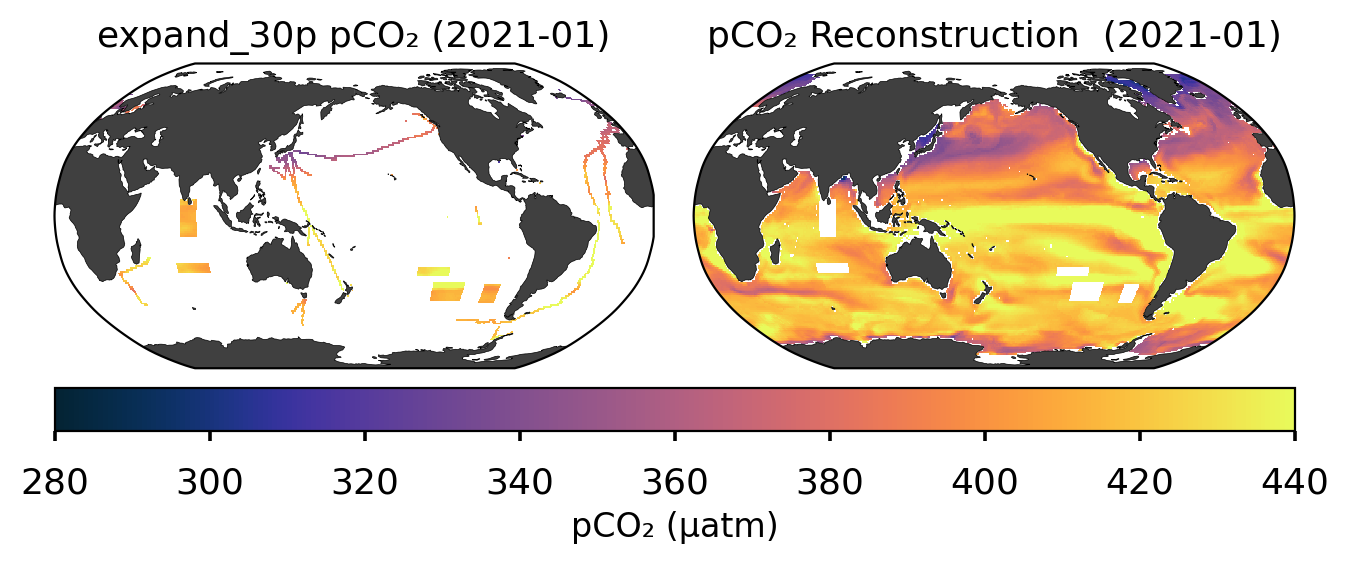

Member path: leap-persistent/abbysh/pco2_all_members_1982-2023/00_regridded_members/ACCESS-ESM1-5/member_r10i1p1f1/ACCESS-ESM1-5.r10i1p1f1.Omon.zarr
Recon path: gs://leap-persistent/azamkhan99/azamkhan99/pco2_residual/nmse/post02_xgb/reconstructions/expand_52p/ACCESS-ESM1-5/member_r10i1p1f1/recon_pCO2_ACCESS-ESM1-5_member_r10i1p1f1_mon_1x1_200401_202312.zarr


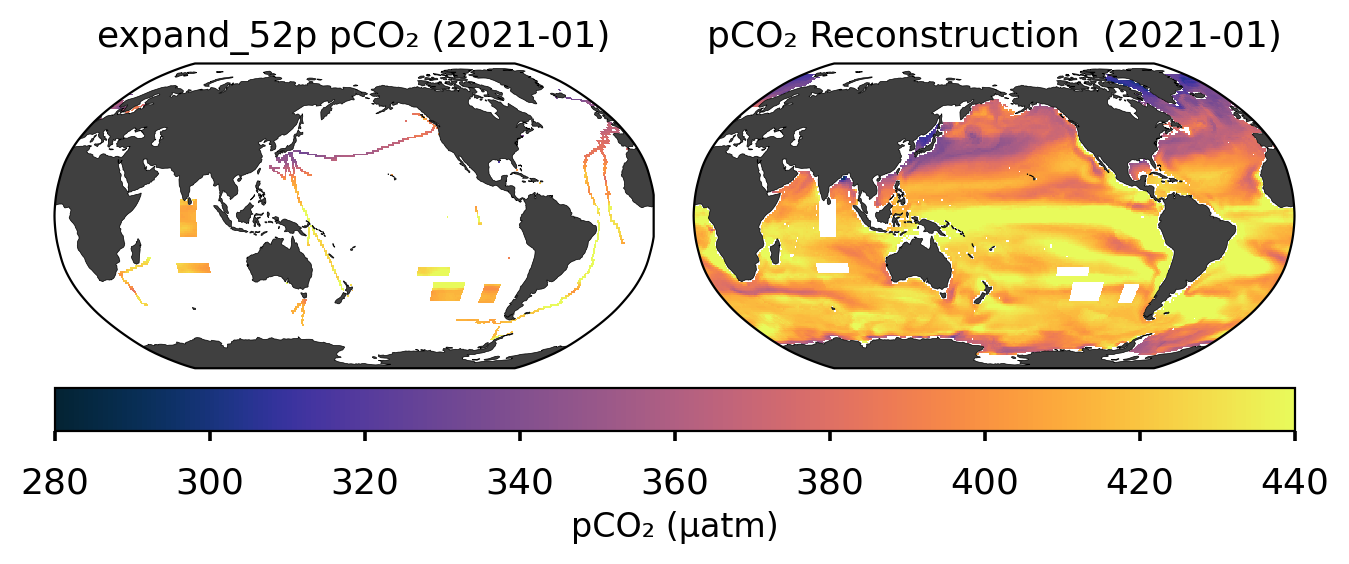

In [162]:


plot_reconstruction_vs_truth(
    mask_name="expand_14p",
    mask_data_dict=mask_data_dict,  # or any other mask from your mask_data_dict
    selected_mems_dict_no_mpi=selected_mems_dict_no_mpi,
    ensemble_dir=ensemble_dir,
    output_dir=output_dir,
    dates=dates,
    init_date=init_date,
    fin_date=fin_date,
)

plot_reconstruction_vs_truth(
    mask_name="expand_30p",
    mask_data_dict=mask_data_dict,  # or any other mask from your mask_data_dict
    selected_mems_dict_no_mpi=selected_mems_dict_no_mpi,
    ensemble_dir=ensemble_dir,
    output_dir=output_dir,
    dates=dates,
    init_date=init_date,
    fin_date=fin_date,
)

plot_reconstruction_vs_truth(
    mask_name="expand_52p",
    mask_data_dict=mask_data_dict,  # or any other mask from your mask_data_dict
    selected_mems_dict_no_mpi=selected_mems_dict_no_mpi,
    ensemble_dir=ensemble_dir,
    output_dir=output_dir,
    dates=dates,
    init_date=init_date,
    fin_date=fin_date,
)



### Sampling strategy: adding more samples in already-sampled locations but not changing the spatial coverage

Member path: leap-persistent/abbysh/pco2_all_members_1982-2023/00_regridded_members/ACCESS-ESM1-5/member_r10i1p1f1/ACCESS-ESM1-5.r10i1p1f1.Omon.zarr
Recon path: gs://leap-persistent/azamkhan99/azamkhan99/pco2_residual/nmse/post02_xgb/reconstructions/densify_mean_pattern/ACCESS-ESM1-5/member_r10i1p1f1/recon_pCO2_ACCESS-ESM1-5_member_r10i1p1f1_mon_1x1_200401_202312.zarr


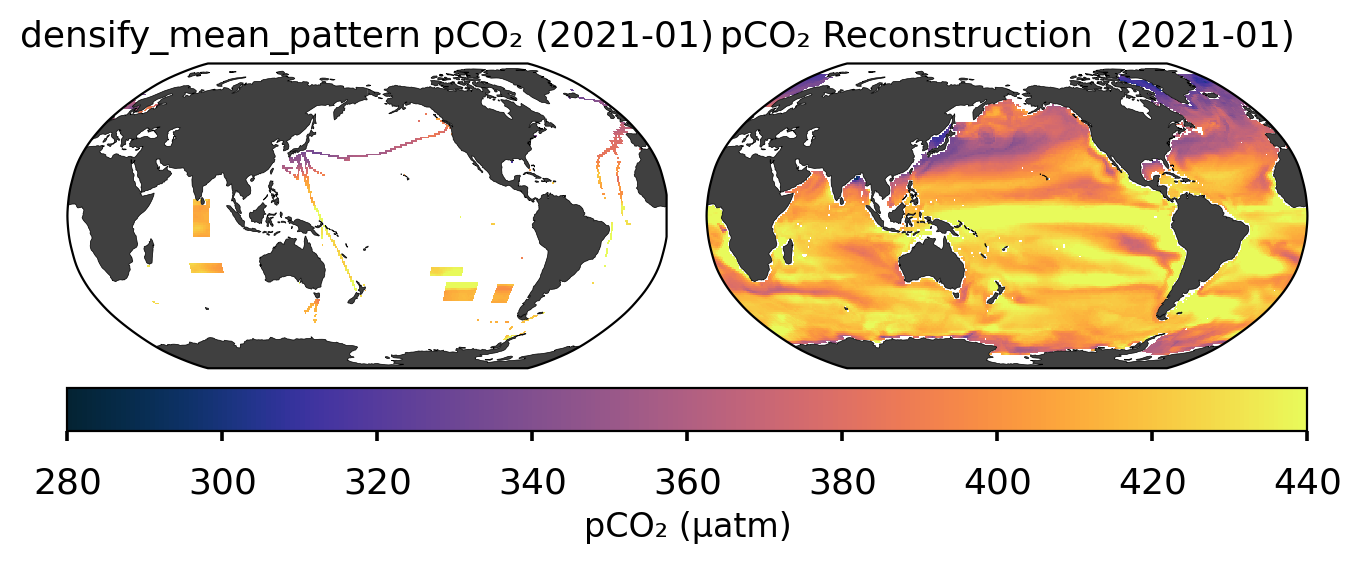

Member path: leap-persistent/abbysh/pco2_all_members_1982-2023/00_regridded_members/ACCESS-ESM1-5/member_r10i1p1f1/ACCESS-ESM1-5.r10i1p1f1.Omon.zarr
Recon path: gs://leap-persistent/azamkhan99/azamkhan99/pco2_residual/nmse/post02_xgb/reconstructions/densify_30p/ACCESS-ESM1-5/member_r10i1p1f1/recon_pCO2_ACCESS-ESM1-5_member_r10i1p1f1_mon_1x1_200401_202312.zarr


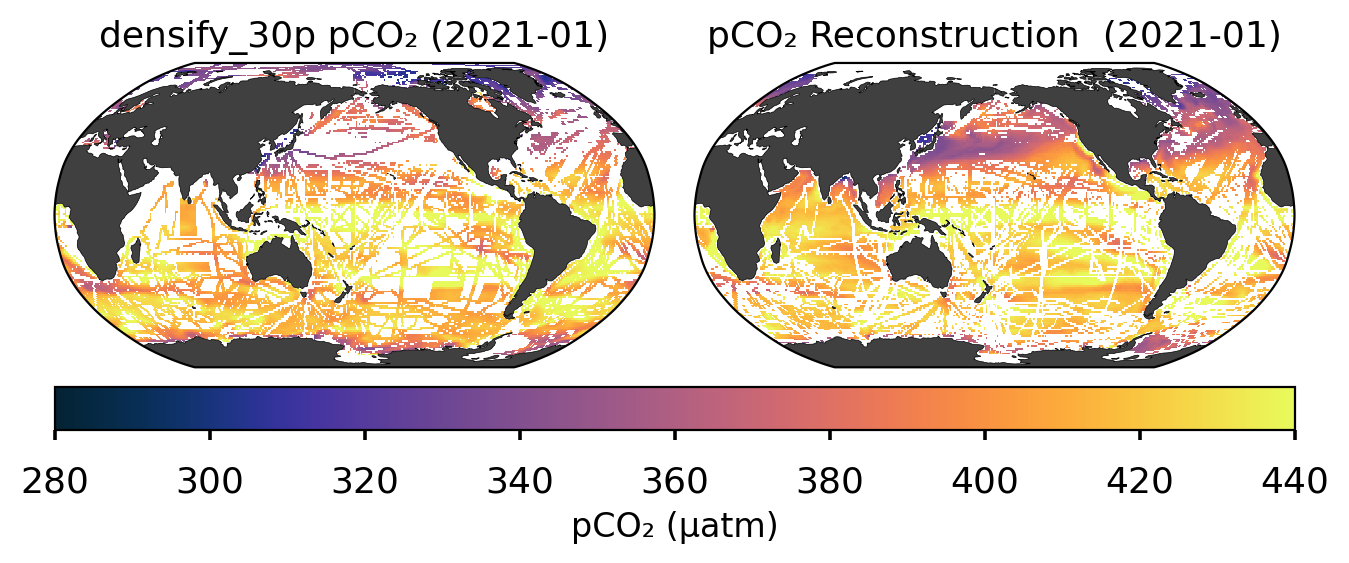

Member path: leap-persistent/abbysh/pco2_all_members_1982-2023/00_regridded_members/ACCESS-ESM1-5/member_r10i1p1f1/ACCESS-ESM1-5.r10i1p1f1.Omon.zarr
Recon path: gs://leap-persistent/azamkhan99/azamkhan99/pco2_residual/nmse/post02_xgb/reconstructions/densify_50p/ACCESS-ESM1-5/member_r10i1p1f1/recon_pCO2_ACCESS-ESM1-5_member_r10i1p1f1_mon_1x1_200401_202312.zarr


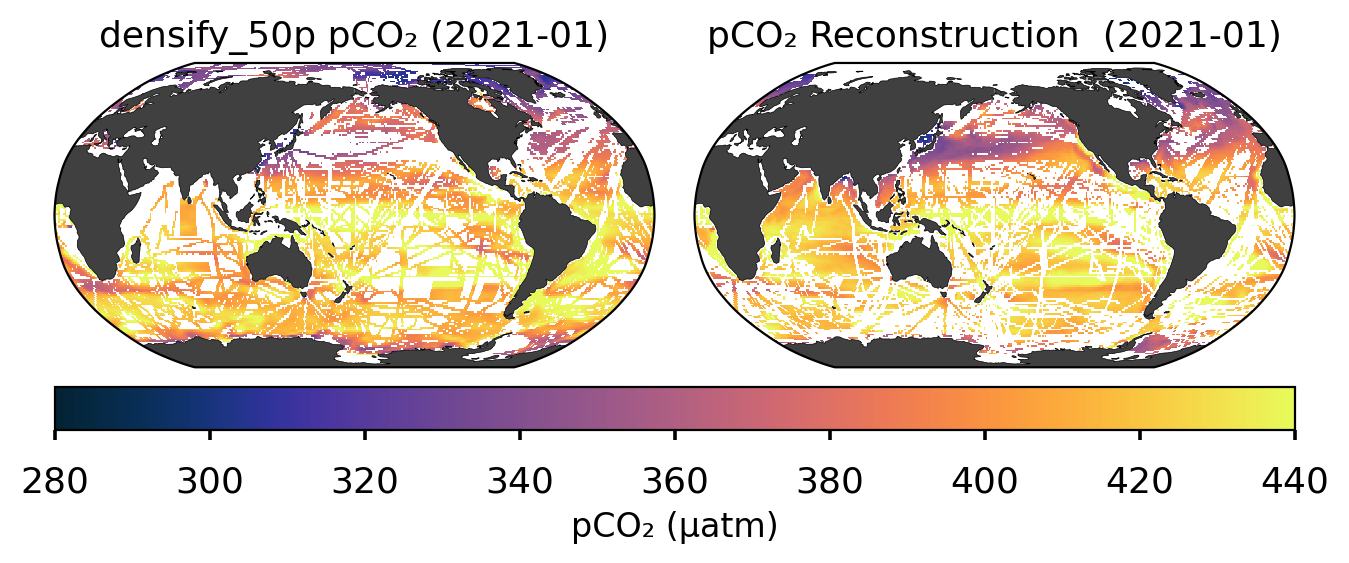

In [163]:
plot_reconstruction_vs_truth(
    mask_name="densify_mean_pattern",
    mask_data_dict=mask_data_dict,  # or any other mask from your mask_data_dict
    selected_mems_dict_no_mpi=selected_mems_dict_no_mpi,
    ensemble_dir=ensemble_dir,
    output_dir=output_dir,
    dates=dates,
    init_date=init_date,
    fin_date=fin_date,
)

plot_reconstruction_vs_truth(
    mask_name="densify_30p",
    mask_data_dict=mask_data_dict,  # or any other mask from your mask_data_dict
    selected_mems_dict_no_mpi=selected_mems_dict_no_mpi,
    ensemble_dir=ensemble_dir,
    output_dir=output_dir,
    dates=dates,
    init_date=init_date,
    fin_date=fin_date,
)

plot_reconstruction_vs_truth(
    mask_name="densify_50p",
    mask_data_dict=mask_data_dict,  # or any other mask from your mask_data_dict
    selected_mems_dict_no_mpi=selected_mems_dict_no_mpi,
    ensemble_dir=ensemble_dir,
    output_dir=output_dir,
    dates=dates,
    init_date=init_date,
    fin_date=fin_date,
)

